# Определение перспективного тарифа для телеком компании  

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей  

*Примечание:* «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  

**Описание данных**  

*Таблица users (информация о пользователях):*
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана  

*Таблица calls (информация о звонках):*
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

*Таблица messages (информация о сообщениях):*
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

*Таблица internet (информация об интернет-сессиях):*
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

*Таблица tariffs (информация о тарифах):*
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Краткий план работы**
1. Знакомство с вводными данными
2. Предобработка данных
3. Анализ данных
4. Проверка гипотез
5. Общий вывод

### Шаг 1. Открытие файла с данными и изучение общей информации

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from IPython.display import display

* Взглянем на таблицу информации о пользователях

In [2]:
users = pd.read_csv('/datasets/users.csv')
display(users, users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


None

В столбце churn_date есть пропущенные значения (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).  
В столбцах churn_date и reg_date должен быть тип datetime, а не object. 

* Взглянем на таблицу информации о звонках

In [3]:
calls=pd.read_csv('/datasets/calls.csv')
display(calls, calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


None

Пропущенных значений нет, это хорошо.  
В столбце call_date должен быть тип datetime, а не object.  
Длительность звонка нужно округлить до целого числа в большую сторону (условие оператора «Мегалайн»)

* Взглянем на таблицу информации о сообщениях

In [4]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages, messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


None

Пропущенных значений нет.  
В столбце message_date должен быть тип datetime, а не object.  

* Взглянем на таблицу информации об интернет-сессиях

In [5]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet, internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


None

Пропущенных значений нет.  
В столбце session_date должен быть тип datetime, а не object.  
Объём потраченного за сессию интернет-трафика нужно округлить до целого числа в большую сторону (условие оператора «Мегалайн»).
Столбец Unnamed: 0 лишний, его можно удалить.

* Взглянем на таблицу информации о тарифах

In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs, tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


None

Пропущенных значений нет.  

### Шаг 2. Подготовка данных

#### 2.1. Приведём данные к нужным типам, исправим ошибки, создадим дополнительный столбец с месяцем операции

* Таблица информации о пользователях

In [7]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

* Таблица информации о звонках

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Округлим минуты вверх, по правилам оператора
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

#создадим столбец с месяцем операции
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


* Таблица информации о сообщениях

In [9]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#создадим столбец с месяцем операции
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


* Таблица информации об интернет-сессиях

In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# Округлим мегабайты вверх, по правилам оператора
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

# удалим лишний столбец Unnamed: 0
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]

#создадим столбец с месяцем операции
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-25,1000,11
1,1000_1,1053,2018-09-07,1000,9
2,1000_2,1198,2018-06-25,1000,6
3,1000_3,551,2018-08-22,1000,8
4,1000_4,303,2018-09-24,1000,9


* Таблица информации о тарифах

Оставляем без изменений

#### 2.2. Посчитаем индивидуальные показатели для каждого пользователя и сведём в общую таблицу

* Сгруппируем таблицы по звонкам, сообщениям и трафику

In [11]:
user_calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
user_messages = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
user_internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

* Объединим вcе таблицы в одну, для удобства анализа

In [12]:
df = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
df = df.merge(user_internet, on=['user_id', 'month'], how='left')
df = df.merge(users, on='user_id', how='left')
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
df = df.merge(tariffs, on='tariff', how='left')

# Переименуем столбцы 
df.rename(columns={'duration': 'duration_sum','id_x': 'calls_sum','id_y': 'messages_sum','mb_used': 'mb_sum'}, inplace=True)
df.head()

,user_id,month,duration_sum,calls_sum,messages_sum,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [13]:
len(df['user_id'].unique())

498

#### 2.3. Посчитаем помесячную выручку с каждого пользователя и добавим в таблицу

In [14]:
# Посчитаем перерасход по гигабайтам, с учетом округления оператора
df['gb_overspending'] = (df['mb_sum'] - df['mb_per_month_included']) / 1024
df['gb_overspending'] = df['gb_overspending'].fillna(0).apply(np.ceil).astype(int)

In [15]:
# Напишем функцию для вычисления помесячной выручки
def total_revenue(row):
    minutes_revenue = 0
    messages_revenue = 0
    gb_revenue = 0
    if (row['duration_sum'] -  row['minutes_included']) > 0:
        minutes_revenue = (row['duration_sum'] -  row['minutes_included']) * row['rub_per_minute'] 
        
    if (row['messages_sum'] - row['messages_included']) > 0:
        messages_revenue = (row['messages_sum'] - row['messages_included']) * row['rub_per_message'] 

    if row['gb_overspending'] > 0:
        gb_revenue = row['gb_overspending'] * row['rub_per_gb']

    return minutes_revenue + messages_revenue + gb_revenue

# Добавим значения в сводную таблицу
df['total_revenue'] = df.apply(total_revenue, axis=1)
df['total_revenue'] = df['total_revenue'] + df['rub_monthly_fee']
df['total_revenue'] = df['total_revenue'].astype(int)
df[['user_id','month','duration_sum','messages_sum','mb_sum','total_revenue']]

,user_id,month,duration_sum,messages_sum,mb_sum,total_revenue
0,1000,5,159.0,22.0,2256.0,1950
1,1000,6,172.0,60.0,23257.0,1950
2,1000,7,340.0,75.0,14016.0,1950
3,1000,8,408.0,81.0,14070.0,1950
4,1000,9,466.0,57.0,14581.0,1950
...,...,...,...,...,...,...
3208,1489,8,NaN,17.0,11066.0,550
3209,1489,9,NaN,32.0,17232.0,950
3210,1489,10,NaN,21.0,19588.0,1550
3211,1489,11,NaN,20.0,17516.0,1150


In [16]:
calls[calls['duration']==0]['duration'].count()

39613

In [17]:
df[df['duration_sum']==0]['duration_sum'].count()

6

### Шаг 3. Проведём анализ данных поведения клиентов оператора

* Проанализируем сколько минут разговора требуется пользователям в месяц на разных тарифах. Построим гистограмму.

In [18]:
df.pivot_table(index = ['tariff'], values = 'duration_sum', aggfunc = ['count', 'mean', 'median', np.var, np.std])

,count,mean,median,var,std
,duration_sum,duration_sum,duration_sum,duration_sum,duration_sum
tariff,,,,,
smart,2223,419.062978,423.0,35844.189551,189.325618
ultra,951,545.451104,528.0,94203.418396,306.925754


Пользователям тарифа **SMART** в среднем требуется **419** мин разговора в месяц.  
Дисперсия 35844. Стандартное отклонение 189 мин.  

Пользователям тарифа **ULTRA** в среднем требуется **545** мин разговора в месяц.  
Дисперсия 94203. Стандартное отклонение 306 мин.  

In [34]:
px.histogram(df, x = 'duration_sum', color = 'tariff', marginal = 'box',
             title = 'Длительность звонков абонентов на тарифах SMART и ULTRA')

![1](https://i.ibb.co/NZRzBP9/newplot-1.png)

Как видно из гистограммы 75% общей длительности звонков на тарифе SMART менее 545 мин. Пользователи стараются уложиться в 500 бесплатных минут входящих в тарифный план. Тогда как длительность звонков на тарифе ULTRA может достигать 1410 мин, ведь в тариф включено 3000 мин в месяц.  
Распределение для клиентов тарифа SMART при звонках более плотное, стандартное отклонение значительно меньше. Это говорит о большей однородности поведения абонантов. В то же время, поведение клиентов тарифа ULTRA разнородно. 

* Проанализируем сколько сообщений требуется пользователям в месяц на разных тарифах. Построим гистограмму.

In [20]:
df.pivot_table(index = ['tariff'],values = 'messages_sum', aggfunc = ['count', 'mean', 'median', np.var, np.std] )

,count,mean,median,var,std
,messages_sum,messages_sum,messages_sum,messages_sum,messages_sum
tariff,,,,,
smart,1922,38.716441,34.0,717.594201,26.787949
ultra,795,61.161006,51.0,2109.659183,45.931026


Пользователям тарифа **SMART** в среднем требуется **38** смс в месяц.  
Дисперсия 717. Стандартное отклонение 26 смс.  

Пользователям тарифа **ULTRA** в среднем требуется **61** смс в месяц.    
Дисперсия 2109. Стандартное отклонение 45 смс.  

In [21]:
px.histogram(df, x = 'messages_sum', color = 'tariff', marginal = 'box',
                  title = 'Количество смс отправляемых абонентами на тарифах SMART и ULTRA')

![2](https://i.ibb.co/2ZGbCwn/newplot-2.png.png)

Как видно из гистограммы 75% общего количества смс на тарифе SMART менее 55 шт. Пользователи стараются уложиться в 50 бесплатных смс входящих в тарифный план. Тогда как количество сообщений на тарифе ULTRA на много больше, может достигать 185 смс. Тариф включает 1000 смс в месяц.  
Гистограммы обоих тарифов скошены влево, особенно это видно по тарифу SMART. Медианные значения так же смещены в сторону 1 квартиля. Это говорит о том, что пользователи либо мало пользуются смс, либо не отправляют их вовсе. В современном мире люди всё чаще используют мессенджеры.

* Проанализируем объём интернет-трафика который требуется пользователям в месяц на разных тарифах. Построим гистограмму.

In [22]:
df.pivot_table(index = ['tariff'],values = 'mb_sum', aggfunc = ['count', 'mean', 'median', np.var, np.std])

,count,mean,median,var,std
,mb_sum,mb_sum,mb_sum,mb_sum,mb_sum
tariff,,,,,
smart,2228,16236.472621,16532.0,3.444310e+07,5868.824472
ultra,974,19706.434292,19427.5,9.876772e+07,9938.194928


Пользователям тарифа **SMART** в среднем требуется **16236** Мб интернет-трафика в месяц.  
Дисперсия 3,4*10^7. Стандартное отклонение 5868 Мб.  

Пользователям тарифа **ULTRA** в среднем требуется **19706** Мб интернет-трафика в месяц.    
Дисперсия 9,8*10^7. Стандартное отклонение 9938 Мб.  

In [23]:
px.histogram(df, x = 'mb_sum', color = 'tariff', marginal = 'box',
                  title = 'Объём интернет-трафика который требуется абонентам на тарифах SMART и ULTRA')

![3](https://i.ibb.co/Gv67yKd/newplot-3.png.png)

Как видно из гистограммы 75% пользователей на тарифе SMART используют менее 19,5 Гб интернет трафика в месяц. То есть большинство старается уложиться в 15 Гб входящих в тарифный план. На тарифе ULTRA абоненты пользуются интернетом больше, 75%-ый показатель у них составляет 26 Гб в месяц. А максимальные значения достигают 48,5 Гб в месяц.  
Интернет является наиболее востребованной услугой в обоих тарифных планах. Количество абонентов которые не пользовались интернетом минимально, при этом есть весомая доля людей, готовых переплачивать за гигабайты сверх тарифного пакета.

* Дополнительно проанализируем общую выручку на разных тарифах. Построим гистограмму.

In [24]:
df.pivot_table(index = ['tariff'],values = 'total_revenue', aggfunc = ['count', 'mean', 'median', 'sum', np.var, np.std])

,count,mean,median,sum,var,std
,total_revenue,total_revenue,total_revenue,total_revenue,total_revenue,total_revenue
tariff,,,,,,
smart,2229,1294.639300,1038,2885751,673931.321363,820.933202
ultra,984,2071.189024,1950,2038050,143622.287733,378.975313


Из сводной таблицы видим, что **тариф SMART более популярен** у абонентов. В течении года люди выбирали его в 2 раза чаще чем тариф ULTRA.

Средняя выручка на тарифе **SMART** получилась **1294** руб. Это в 2 раза больше ежемесячной платы. Следовательно люди на данном тарифе активно пользуются услугами сверх тарифного пакета.
Средняя выручка на тарифе **ULTRA** получилась **2071** руб. Она практически равна ежемесячной плате на данном тарифе. Дополнительно здесь ни чего не покупают, всех услуг хватает с запасом.

Общая выручка на тарифе **SMART 2,9 млн.руб**. На тарифе **ULTRA 2 млн.руб**. Выручка различается, но не в разы.

In [25]:
px.histogram(df, x = 'total_revenue', color = 'tariff', marginal = 'box',
                  title = 'Объём интернет-трафика который требуется абонентам на тарифах SMART и ULTRA')

![4](https://i.ibb.co/S369ykQ/newplot-4.png)

Гистограмма подтверждает утверждения описанные нами выше . На тарифе SMART только **25%** не пользуются дополнительными услугами сверх тарифного плана (первый квартиль равен 550 руб), остальные клинеты покупают допы.  
Два больших столбца отображают количество клиентов, которые не переплачивают сверх тарифного плана. На тарифе SMART таких **850** (из общего числа 984) - абсолютное большинство.

* Дополнительно посмотрим на динамику подключений / отключений тарифов по месяцам. Построим гистограмму.

In [26]:
users['reg_month'] = pd.DatetimeIndex(users['reg_date']).month
users['churn_month'] = pd.DatetimeIndex(users['churn_date']).month
users['month'] = users['reg_month']

In [27]:
tariff_reg_churn = users.pivot_table(index=['tariff', 'month'], values=['reg_month', 'churn_month'], aggfunc = 'count')
tariff_reg_churn = tariff_reg_churn.reset_index(level='month')
display(tariff_reg_churn)

,month,churn_month,reg_month
tariff,,,
smart,1,1,34
smart,2,2,24
smart,3,2,19
smart,4,2,35
smart,5,1,29
smart,6,1,23
smart,7,3,37
smart,8,1,34
smart,9,1,26


<AxesSubplot:title={'center':'smart'}, xlabel='month'>

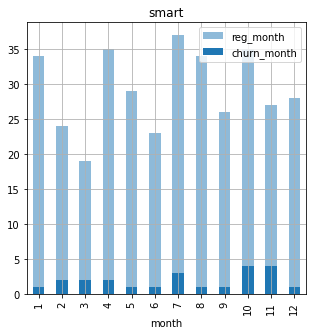

In [28]:
ax=tariff_reg_churn[tariff_reg_churn.index=='smart'].plot(
    x='month', y='reg_month',figsize=(5,5),kind='bar',alpha=0.5,label='reg_month', title='smart')
tariff_reg_churn[tariff_reg_churn.index=='smart'].plot(
    x='month', y='churn_month',grid=True,figsize=(5,5),kind='bar',label='churn_month',ax=ax)

<AxesSubplot:title={'center':'ultra'}, xlabel='month'>

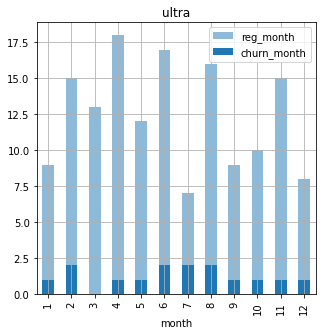

In [29]:
ax=tariff_reg_churn[tariff_reg_churn.index=='ultra'].plot(
    x='month', y='reg_month',figsize=(5,5),kind='bar',alpha=0.5,label='reg_month', title='ultra')
tariff_reg_churn[tariff_reg_churn.index=='ultra'].plot(
    x='month', y='churn_month',grid=True,kind='bar',label='churn_month',ax=ax)

На гистограммах выше видно, что тариф "Смарт" имеет положительную динамику - количество подключений растет от месяца к месяцу.  
На тарифе "Ультра" наоборот динамика отрицательная, с каждым месяцем к нему подключаются всё меньше абонентов.  
Делаем вывод, что именно **для тарифа "Ультра" нужно увеличивать рекламный бюджет**, для того чтобы поддержать продажи тарифа.

### Шаг 4. Проведём проверку гипотез

* **Первая гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

Выдвинем нулевую гипотезу **H0**: Средняя выручка пользователей тарифа "Ультра" **равна** средней выручке пользователей тарифа "Смарт".

Альтернативная гипотеза **H1**: Средняя выручка пользователей тарифа "Ультра" **не равна** средней выручке пользователей тарифа "Смарт".

In [30]:
# Установим критический уровень статистической значимости:
alpha = 0.05

total_revenue_smart = df.query('tariff == "smart"')['total_revenue']
total_revenue_ultra = df.query('tariff == "ultra"')['total_revenue']

results = st.ttest_ind(total_revenue_smart, total_revenue_ultra, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.2772041270985486e-246
Отвергаем нулевую гипотезу


*Вывод:* Средняя выручка пользователей тарифов «Ультра» и «Смарт» **различается**.

* **Вторая гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

Выдвинем нулевую гипотезу **H0**: Средняя выручка пользователей из Москвы **равна** выручке пользователей из других регионов.

Альтернативная гипотеза **H1**: Средняя выручка пользователей из Москвы **не равна** выручке пользователей из других регионов.

In [31]:
# Установим критический уровень статистической значимости:
alpha = 0.05

total_revenue_moscow = df.query('city == "Москва"')['total_revenue']
total_revenue_other = df.query('city != "Москва"')['total_revenue']

results = st.ttest_ind(total_revenue_moscow, total_revenue_other, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5254578510057593
Не получилось отвергнуть нулевую гипотезу


In [32]:
display(total_revenue_moscow.var())
display(total_revenue_other.var())

566850.624178309

656766.5955122437

*Вывод:* Средняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов.

### Шаг 5. Сделаем общий вывод

В ходе исследования мы обработали и проанализировали пердоставленные нам данные **500 пользователей** федерального оператора сотовой связи, **кампании «Мегалайн» за 2018 год**. В процессе сравнительного анализа по двум тарифным планам «Смарт» и «Ультра», было установленно следующее:   

* Пользователям тарифа **«Смарт»**, в среднем, требуется **419 минут**, **38 смс** и **16 Гб** интернет-трафика в месяц.  
Пользователям тарифа **«Ультра»**, в среднем, требуется **545 минут**, **61 смс** и **19 Гб** интернет-трафика в месяц.  
Полученные значения минут, смс и Гб не так сильно отличаются между тарифами, тогда как базовая стоимость тарифов отличается почти в 4 раза. **Тариф «Ультра» более прибыльный чем тариф «Смарт»**.  
  

* Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. У абонентов тарифа «Ультра» она выше.  
При этом суммарная выручка выше на тарифе «Смарт». Пользователей тарифа «Смарт» на много больше и они чаще переплачивают за дополнительные  услуги. Делаем вывод, что **оба тарифа важны**.  


* Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. **Рекламную компанию нужно делать по всей территории распространения сети**.